In [11]:
import tensorflow as tf
import multiprocessing as mp
import matplotlib.pyplot as plt

In [12]:
from keras import backend as K
# tf.config.set_visible_devices([], 'GPU') # für CPU usage
config = tf.compat.v1.ConfigProto(device_count = {'GPU': len(tf.config.list_physical_devices('GPU')), # sollte 1 sein, weil wir nur eine GPU haben
                                                  'CPU': mp.cpu_count()})                             # sollte 64 sein, weil wir 64 CPU Kerne haben
sess = tf.compat.v1.Session(config=config) 
K.set_session(sess)

2023-06-06 18:39:47.081036: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78918 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:c0:00.0, compute capability: 8.0


### Paths

In [13]:
DATASET_PATH = "/scratch/schneialexan/dataset/"

TEST_PATH = DATASET_PATH + "test_32/"
TRAIN_PATH = DATASET_PATH + "train_32/"

TEST_PATH_N = TEST_PATH + "n/"
TEST_PATH_Y = TEST_PATH + "y/"
TRAIN_PATH_N = TRAIN_PATH + "n/"
TRAIN_PATH_Y = TRAIN_PATH + "y/"

In [14]:
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc)+1)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    # Plot training and validation accuracy per epoch
    ax1.plot(epochs, acc, 'bo', label='Training acc')
    ax1.plot(epochs, val_acc, 'r-', label='Validation acc')
    ax1.set_title('Training and validation accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    # Plot training and validation loss per epoch
    ax2.plot(epochs, loss, 'bo', label='Training loss')
    ax2.plot(epochs, val_loss, 'r-', label='Validation loss')
    ax2.set_title('Training and validation loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    return fig

### Data Generation

In [15]:
TARGET_SIZE = (500, 500)  # Adjusted to a smaller size
EPOCHS = 10
STEPS_PER_EPOCH = 100
VAL_STEPS = 50
BATCH_SIZE = 32  # Increased batch size

In [16]:
# NO DATA AUGMENTATION
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
train_gen = datagen.flow_from_directory(TRAIN_PATH,
                                       target_size = TARGET_SIZE,
                                       batch_size = BATCH_SIZE,
                                       class_mode = 'binary')
val_gen = datagen.flow_from_directory(TEST_PATH,
                                      target_size = TARGET_SIZE,
                                      batch_size = BATCH_SIZE,
                                      class_mode = 'binary')

Found 95 images belonging to 2 classes.
Found 39 images belonging to 2 classes.


### Base Model

In [17]:
def base_model():
    model = tf.keras.models.Sequential()
    # CNN Block 1
    model.add(tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', input_shape=(TARGET_SIZE[0],TARGET_SIZE[1],3)))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    # CNN Block 2
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    # CNN Block 3
    model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    # Classification Block
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(256, activation= 'relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    return model
baseline_model = base_model()
baseline_model.compile(loss = 'binary_crossentropy',
                       optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
                       metrics=['acc'])
baseline_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 498, 498, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 249, 249, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 247, 247, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 123, 123, 64)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 121, 121, 128)     73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 60, 60, 128)     

In [20]:
baseline_history = baseline_model.fit(
        train_gen,
        epochs = EPOCHS,
        validation_data=val_gen
    )

Epoch 1/10


2023-06-06 18:40:10.748284: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


3/3 [==============================] - ETA: 0s - loss: 0.6505 - acc: 0.6632

2023-06-06 18:40:15.558252: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


3/3 [==============================] - 6s 3s/step - loss: 0.6505 - acc: 0.6632 - val_loss: 0.4530 - val_acc: 0.8974
Epoch 2/10
3/3 [==============================] - 5s 2s/step - loss: 0.6566 - acc: 0.6632 - val_loss: 0.4669 - val_acc: 0.8974
Epoch 3/10
3/3 [==============================] - 5s 2s/step - loss: 0.6491 - acc: 0.6632 - val_loss: 0.4937 - val_acc: 0.8974
Epoch 4/10
3/3 [==============================] - 5s 2s/step - loss: 0.6481 - acc: 0.6632 - val_loss: 0.5482 - val_acc: 0.8974
Epoch 5/10
3/3 [==============================] - 5s 2s/step - loss: 0.6481 - acc: 0.6632 - val_loss: 0.5359 - val_acc: 0.8974
Epoch 6/10
3/3 [==============================] - 5s 2s/step - loss: 0.6483 - acc: 0.6632 - val_loss: 0.4948 - val_acc: 0.8974
Epoch 7/10
3/3 [==============================] - 5s 2s/step - loss: 0.6434 - acc: 0.6632 - val_loss: 0.4934 - val_acc: 0.8974
Epoch 8/10
3/3 [==============================] - 5s 2s/step - loss: 0.6430 - acc: 0.6632 - val_loss: 0.5047 - val_acc: 0.

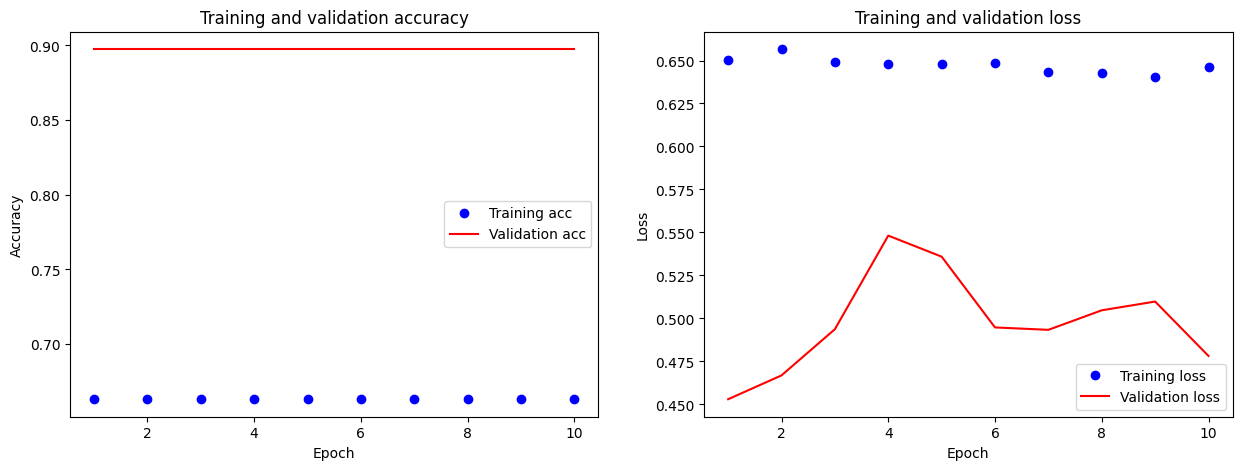

In [21]:
plot_history(baseline_history);